# How to run nodes in parallel

## Introduction
In this tutorial, you will learn how to run node in parallel.

Load the AiiDA profile.

In [1]:
%load_ext aiida
from aiida import load_profile
load_profile()

Profile<uuid='4a9501fb20364cecb99920cadf27b238' name='xing'>

## First workflow
Suppose we want to calculate ```(x + y) * z ``` in two steps. First, add `x` and `y`, then multiply the result with `z`. And `X` is a list of values. We want to calculate these in parallel.


### Create node
First, one should know that we can not launch a subprocess inside a `node` or a `calcfunction`. We need a create a `WorkTree` to run nodes in parallel. And then treat this `WorkTree` as a node.

In [2]:
from aiida_worktree import node, WorkTree
from aiida.engine import calcfunction
from aiida.orm import List


# define multiply node
@node()
@calcfunction
def multiply(x, y):
    return x*y

# Create a WorkTree as a node
@node.group()
def multiply_parallel(X, y):
    from aiida.orm import load_node
    wt = WorkTree("multiply_parallel")
    # here the node `multiply` is created and will run in parallel
    for key, value in X.items():
        wt.nodes.new(multiply, x=value, y=y)
    # don't forget to return the wt
    return wt

### Create the workflow


In [3]:
from aiida_worktree import WorkTree
from aiida.orm import Int, List

X = {"a": Int(1), "b": Int(2), "c": Int(3)}
y = Int(2)
z = Int(3)
wt = WorkTree("parallel_node")
multiply_parallel1 = wt.nodes.new(multiply_parallel, name="multiply_parallel1", X=X, y=y)

wt.submit(wait=True)

[INFO] 2023-08-03 22:39:11 nodetree: Create NodeTree: parallel_node


### Check the status and results


In [4]:
print("State of WorkTree:   {}".format(wt.state))

State of WorkTree:   FINISHED


Generate node graph from the AiiDA process:

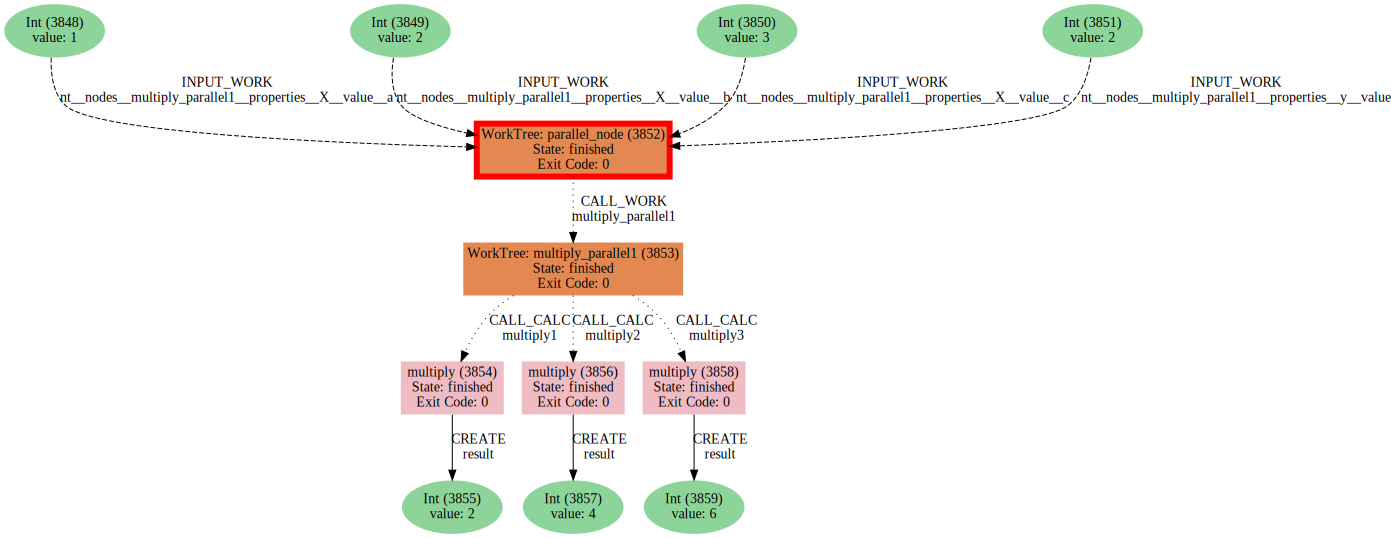

In [5]:
from aiida_worktree.utils import generate_node_graph
generate_node_graph(wt.pk)

## Second workflow: gather results
Now I want to gather the results from the previous `multiply_parallel` nodes and calculate the sum of all their results.
Let's update the `multiply_parallel` function to `multiply_parallel_gather`.

In [6]:
@node.group(outputs = [["ctx", "mul", "result"]])
def multiply_parallel_gather(X, y):
    from aiida.orm import load_node
    wt = WorkTree("multiply")
    for key, value in X.items():
        multiply1 = wt.nodes.new(multiply, x=value, y=y)
        # add result of multiply1 to `self.ctx.mul`
        # self.ctx.mul is a dict {"a": value1, "b": value2, "c": value3}
        multiply1.to_ctx = [["result", f"mul.{key}"]]
    return wt

@node()
@calcfunction
# the input is dynamic, we must use a variable kewword argument. **datas
def sum(**datas):
    from aiida.orm import Float
    total = 0
    for key, data in datas.items():
        total += data
    return Float(total)

Now, let's create a `WorkTree` to use the new node:

In [7]:
from aiida_worktree import WorkTree
from aiida.orm import Int, List

X = {"a": Int(1), "b": Int(2), "c": Int(3)}
y = Int(2)
z = Int(3)
wt = WorkTree("parallel_node")
multiply_parallel_gather1 = wt.nodes.new(multiply_parallel_gather, X=X, y=y)
sum1 = wt.nodes.new(sum, name="sum1")
# wt.links.new(add1.outputs[0], multiply_parallel_gather1.inputs["uuids"])
wt.links.new(multiply_parallel_gather1.outputs[0], sum1.inputs[0])

wt.submit(wait=True)

[INFO] 2023-08-03 22:39:19 nodetree: Create NodeTree: parallel_node


Get the result of the nodes:

In [8]:
print("State of WorkTree:   {}".format(wt.state))
print('Result of node add1: {}'.format(wt.nodes["sum1"].node.outputs.result.value))

State of WorkTree:   FINISHED
Result of node add1: 12.0


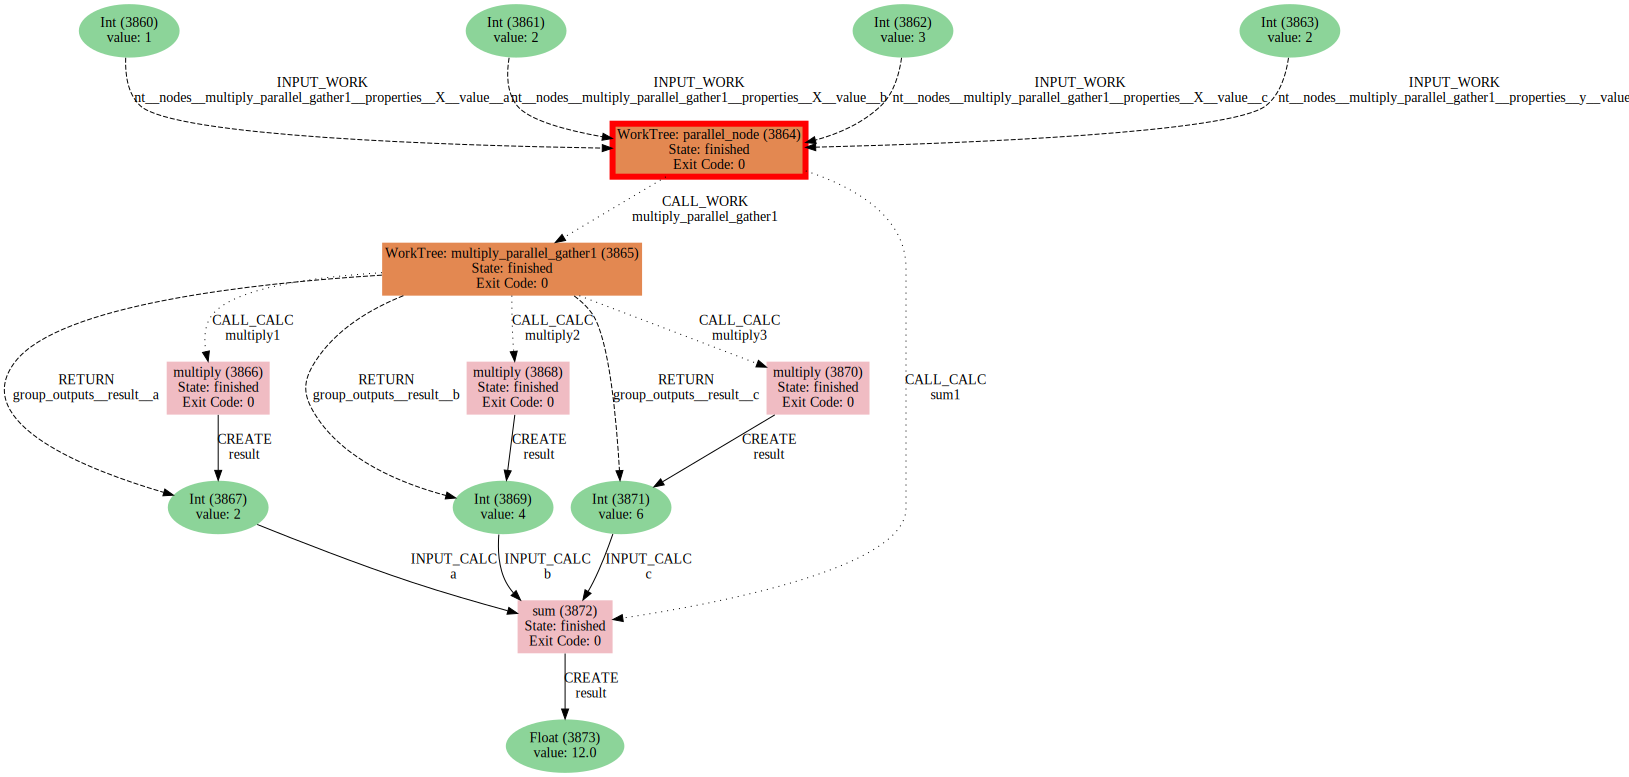

In [9]:
from aiida_worktree.utils import generate_node_graph
generate_node_graph(wt.pk)

You can see that the outputs of `multiply_parallel_gather` worktree is linked to the input of the `sum` node.